In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

sys.path.append(os.path.abspath("../../scripts/"))
from helpers import *
from osmle import *

In [2]:
# Phase 1
steps1=2000
lr1=5e-3
batch_size1=1024
lambda_l1=1e-3

# Threshold
# tau=1e-1 # keep |W| >= tau

# Phase 2
steps2=1500
lr2=5e-3
batch_size2=1024

prefer_cuda=True
seed=123

np.random.seed(seed); torch.manual_seed(seed)
device = device_auto(prefer_cuda)

In [3]:
N=5
K=4000
T=25
beta0=-2.0
w_edge=0.95

beta_gt = np.full(N, float(beta0), dtype=np.float64)
motifs = [
    {"type": "cycle", "nodes": [0,1,2]},
    {"type": "chain", "nodes": [2,3]},
    {"type": "empty", "nodes": [4]}
]

W_gt = generate_W_gt(N, motifs=motifs, w_mean=w_edge, w_std=0.3*w_edge, seed=42)

print(W_gt)

[[0.         0.         1.05277912 0.         0.        ]
 [0.87374119 0.         0.         0.         0.        ]
 [0.         1.10048782 0.         0.         0.        ]
 [0.         0.         1.05277912 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [4]:
# --- Simulate data
s0 = spin_zero(N)
paths = simulate_paths_factorized(beta_gt, W_gt, K=K, T=T, s0=s0, seed=seed)
s_t_np, s_tp1_np = make_one_step_pairs(paths)
s_t   = torch.as_tensor(s_t_np,   dtype=torch.float32, device=device)
s_tp1 = torch.as_tensor(s_tp1_np, dtype=torch.float32, device=device)

# -------- Phase 1: dense off-diagonal mask, with L1 ----------
mask_offdiag = np.ones((N, N), dtype=np.float32); np.fill_diagonal(mask_offdiag, 0.0)
model1 = FactorizedLogisticPrior(N, mask=mask_offdiag).to(device)

_ = train_one_phase(
    model1, s_t, s_tp1,
    steps=steps1, batch_size=batch_size1, lr=lr1,
    l1_weight=lambda_l1, hard_mask_freeze=False, seed=seed+1
)

with torch.no_grad():
    beta_1 = model1.beta.detach().cpu().numpy()
    W_1_full = model1.W.detach().cpu().numpy()
    W_1 = (model1.W * model1.mask).detach().cpu().numpy()  # masked (diag=0)

# ---- Threshold to build sparse mask (absolute value) ----
# edge_mask = (np.abs(W_1) >= float(tau)).astype(np.float32)
nonzero_mean = W_1[W_1 != 0].mean()
nonzero_std = W_1[W_1 != 0].std()
tau = max(0.7, nonzero_mean+(nonzero_std/2))
edge_mask = (W_1 >= float(tau)).astype(np.float32)
np.fill_diagonal(edge_mask, 0.0)
kept = int(edge_mask.sum())

# -------- Phase 2: fixed sparse mask, HARD-enforced ----------
model2 = FactorizedLogisticPrior(N, mask=edge_mask).to(device)
with torch.no_grad():
    model2.beta.copy_(torch.tensor(beta_1, dtype=torch.float32, device=device))
    # initialize W with masked W_1 (pruned entries exactly 0)
    model2.W.copy_(torch.tensor(W_1 * edge_mask, dtype=torch.float32, device=device))

_ = train_one_phase(
    model2, s_t, s_tp1,
    steps=steps2, batch_size=batch_size2, lr=lr2,
    l1_weight=0.0, hard_mask_freeze=True, seed=seed+2
)

with torch.no_grad():
    beta_2 = model2.beta.detach().cpu().numpy()
    W_2 = (model2.W * model2.mask).detach().cpu().numpy()

# ----- report (concise)
np.set_printoptions(precision=3, suppress=True)
print("\n=== SUMMARY ===")
print(f"kept edges after threshold tau={tau}: {kept} / {N*(N-1)} (~{kept/(N*(N-1)):.3f})")
print("\nGround-truth beta:", beta_gt)
print("Phase 1     beta:", beta_1)
print("Phase 2     beta:", beta_2)
print("\nGround-truth W (cycle):\n", W_gt)
print("Phase 1     W (masked offdiag):\n", W_1)
print("Phase 2     W (sparse, fixed mask):\n", W_2)

# Quick sanity: ensure zeros exactly where mask==0
offmask_zero_violation = np.max(np.abs(W_2 * (1.0 - edge_mask)))
print(f"\nMax |W_2| outside mask (should be 0): {offmask_zero_violation:.6f}")


=== SUMMARY ===
kept edges after threshold tau=0.7: 4 / 20 (~0.200)

Ground-truth beta: [-2. -2. -2. -2. -2.]
Phase 1     beta: [-1.482 -1.542 -1.465 -1.459 -1.656]
Phase 2     beta: [-2.003 -2.068 -1.961 -1.971 -2.02 ]

Ground-truth W (cycle):
 [[0.    0.    1.053 0.    0.   ]
 [0.874 0.    0.    0.    0.   ]
 [0.    1.1   0.    0.    0.   ]
 [0.    0.    1.053 0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
Phase 1     W (masked offdiag):
 [[0.    0.223 1.082 0.239 0.093]
 [0.909 0.    0.205 0.179 0.107]
 [0.186 1.163 0.    0.26  0.079]
 [0.214 0.195 1.117 0.    0.103]
 [0.102 0.097 0.104 0.099 0.   ]]
Phase 2     W (sparse, fixed mask):
 [[0.    0.    1.039 0.    0.   ]
 [0.862 0.    0.    0.    0.   ]
 [0.    1.139 0.    0.    0.   ]
 [0.    0.    1.072 0.    0.   ]
 [0.    0.    0.    0.    0.   ]]

Max |W_2| outside mask (should be 0): 0.000000


In [5]:

# === SUMMARY ===
# kept edges after threshold tau=0.15: 4 / 20 (~0.200)

# Ground-truth beta: [-1. -1. -1. -1. -1.]
# Phase 1     beta: [-1.01  -1.027 -0.987 -0.982 -0.987]
# Phase 2     beta: [-1.011 -1.041 -0.981 -0.975 -1.003]

# Ground-truth W (cycle):
#  [[0.    0.    1.053 0.    0.   ]
#  [0.874 0.    0.    0.    0.   ]
#  [0.    1.1   0.    0.    0.   ]
#  [0.    0.    1.423 0.    0.   ]
#  [0.    0.    0.    0.    0.   ]]
# Phase 1     W (masked offdiag):
#  [[ 0.     0.004  1.033  0.008 -0.021]
#  [ 0.87   0.    -0.032 -0.006 -0.004]
#  [-0.017  1.111  0.     0.017  0.002]
#  [ 0.015 -0.017  1.432  0.     0.003]
#  [ 0.001  0.004  0.014 -0.005  0.   ]]
# Phase 2     W (sparse, fixed mask):
#  [[ 0.     0.     1.043  0.    -0.   ]
#  [ 0.862  0.    -0.    -0.    -0.   ]
#  [-0.     1.1    0.     0.     0.   ]
#  [ 0.    -0.     1.425  0.     0.   ]
#  [ 0.     0.     0.    -0.     0.   ]]

# Max |W_2| outside mask (should be 0): 0.000000

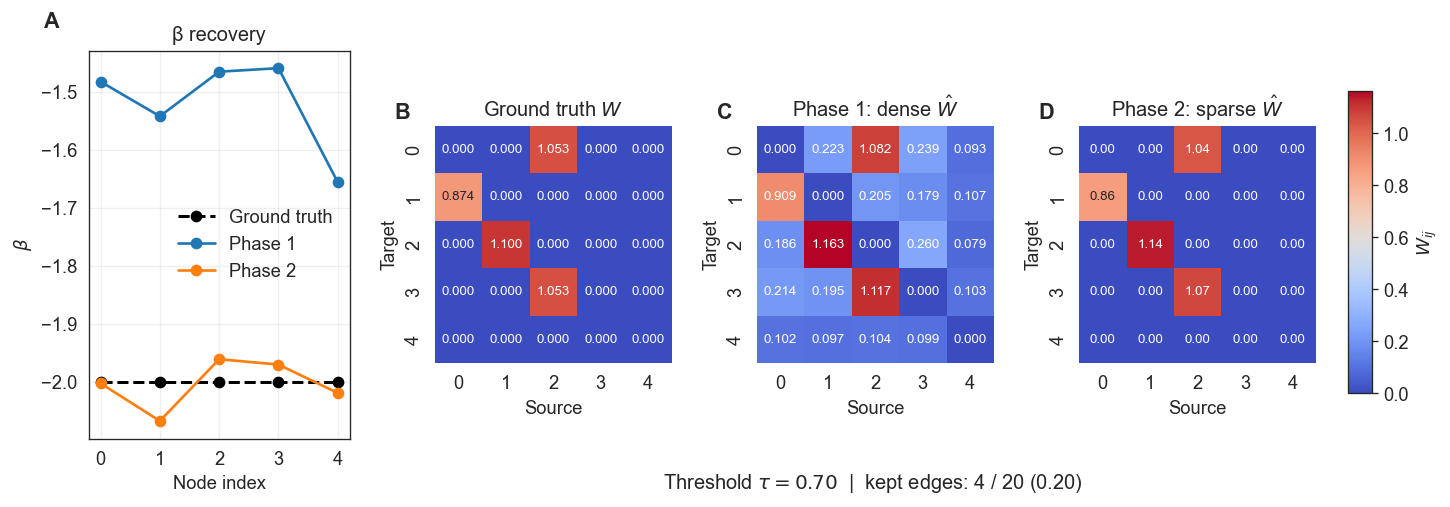

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ----------------- Style -----------------
sns.set_style("white")
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "figure.dpi": 120,
    "savefig.dpi": 300,
})

# ----------------- Global color normalization -----------------
W_all = np.concatenate([
    W_gt.flatten(),
    W_1.flatten(),
    W_2.flatten()
])

norm = Normalize(vmin=W_all.min(), vmax=W_all.max())
cmap = "coolwarm"

# ----------------- Figure layout -----------------
fig = plt.figure(figsize=(13.2, 4.2))
gs = fig.add_gridspec(1, 4, width_ratios=[1.1, 1, 1, 1], wspace=0.35)

# ================= Panel A: Beta recovery =================
ax0 = fig.add_subplot(gs[0, 0])
idx = np.arange(len(beta_gt))

ax0.plot(idx, beta_gt, 'k--o', label="Ground truth", lw=1.8)
ax0.plot(idx, beta_1,  'C0-o', label="Phase 1", lw=1.6)
ax0.plot(idx, beta_2,  'C1-o', label="Phase 2", lw=1.6)

ax0.set_xlabel("Node index")
ax0.set_ylabel(r"$\beta$")
ax0.set_title("β recovery")
# ax0.set_ylim(beta0-0.05, beta0+0.05)
ax0.set_xticks(idx)
ax0.legend(frameon=False)
ax0.grid(alpha=0.3)

# ================= Panel B: Ground truth W =================
ax1 = fig.add_subplot(gs[0, 1])
sns.heatmap(
    W_gt,
    ax=ax1,
    cmap=cmap,
    norm=norm,
    square=True,
    cbar=False,
    annot=True,
    fmt=".3f",
    annot_kws={"fontsize": 8}
)
ax1.set_title("Ground truth $W$")
ax1.set_xlabel("Source")
ax1.set_ylabel("Target")

# ================= Panel C: Phase 1 W =================
ax2 = fig.add_subplot(gs[0, 2])
sns.heatmap(
    W_1,
    ax=ax2,
    cmap=cmap,
    norm=norm,
    square=True,
    cbar=False,
    annot=True,
    fmt=".3f",
    annot_kws={"fontsize": 8}
)
ax2.set_title("Phase 1: dense $\hat{W}$")
ax2.set_xlabel("Source")
ax2.set_ylabel("Target")

# ================= Panel D: Phase 2 W =================
ax3 = fig.add_subplot(gs[0, 3])
sns.heatmap(
    W_2,
    ax=ax3,
    cmap=cmap,
    norm=norm,
    square=True,
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"fontsize": 8}
)
ax3.set_title("Phase 2: sparse $\hat{W}$")
ax3.set_xlabel("Source")
ax3.set_ylabel("Target")

# ----------------- Single shared colorbar -----------------
cax = fig.add_axes([0.92, 0.20, 0.015, 0.60])
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, cax=cax, label=r"$W_{ij}$")

# ----------------- Annotation near matrices -----------------
total_edges = N * (N - 1)
fig.text(
    0.62, 0.01,   # centered under matrix panels
    rf"Threshold $\tau={tau:.2f}$  |  kept edges: {kept} / {total_edges} "
    rf"({kept/total_edges:.2f})",
    ha="center",
    fontsize=12
)

# ----------------- Panel labels -----------------
for label, ax in zip(["A", "B", "C", "D"], [ax0, ax1, ax2, ax3]):
    ax.text(
        -0.17, 1.1, label,
        transform=ax.transAxes,
        fontsize=13,
        fontweight="bold",
        va="top"
    )


plt.savefig("/Users/mariumyousuf/Desktop/neurocomputing/figures/revised-figs/fig2AD_OSTMLE.png")
plt.savefig("/Users/mariumyousuf/Desktop/neurocomputing/figures/revised-figs/fig2AD_OSTMLE.pdf",
           bbox_inches='tight', pad_inches=0.01)
plt.savefig("/Users/mariumyousuf/Desktop/neurocomputing/figures/revised-figs/fig2AD_OSTMLE.svg")
plt.show()